### ST000369 - Random Forest Classifier
Questo dataset, basato su spettrometria di massa a gas-cromatografia (GC-MS), contiene 181 metaboliti identificati nel siero e nel plasma. L'obiettivo principale di questo studio era quello di confrontare i profili metabolici tra pazienti con adenocarcinoma polmonare e individui sani attraverso due studi caso-controllo indipendenti. In questa analisi confrontiamo il gruppo di pazienti con adenocarcinoma polmonare (Classe=1) con il gruppo di controllo sano (Classe=0).

### 1. Import Packages

In [2]:
# Librerie di base
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Librerie per la Data Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# Librerie per il modello di ML
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score

# Librerie per la Hyperparameters Optimization
from sklearn.model_selection import GridSearchCV

# Librerie per la Features Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV

print('All packages successfully loaded')

All packages successfully loaded


### 2. Load Data & Peak Sheet

In [3]:
df = pd.read_excel('../../../data/ST000369.xlsx')

# Rimuoviamo le colonne che non ci servono
df.drop(columns=["Idx", "SampleID", "Class"], inplace=True)

# Visualizziamo le prime 5 righe del dataset
df.head()

,SampleType,HealthState,SmokingStatus,Sex,M1,M2,M3,M4,M5,M6,...,M172,M173,M174,M175,M176,M177,M178,M179,M180,M181
0,Plasma,Adenocarcinoma,Former,F,194,168,77,105985,118,15489,...,195,1606,300,108,7203,43,59,1009,383,68
1,Plasma,Adenocarcinoma,Former,F,215,143,154,100462,133,13534,...,184,364,1364,160,11910,82,99,136,1021,165
2,Plasma,Adenocarcinoma,Current,F,104,67,45,75301,94,7390,...,189,157,884,73,6372,59,35,115,530,72
3,Plasma,Adenocarcinoma,Current,M,360,642,82,42097,84,50943,...,320,1621,461,104,14011,69,86,845,1309,127
4,Plasma,Adenocarcinoma,Current,M,96,137,95,112346,168,41987,...,84,769,266,158,18140,40,87,1213,1037,149


### 2.1 Data cleaning

Per quanto riguarda il data cleaning del dataset, sono necessarie due tipologie di operazioni sui dati: 
1. Alcuni valori della feature "*HealthState*" sono scritti incorrettamente, perciò dobbiamo effettuarne la correzione.
2. Tre features binarie sono espresse attraverso stringhe e non valori binari (0 e 1), perciò dobbiamo fare la sostituzione.

In [4]:
# Effettuiamo la correzione dei valori errati
df["HealthState"] = df["HealthState"].str.replace('Adenocarcnoma', 'Adenocarcinoma')

# Convertiamo i valori di natura categorica in valori numerici
df['Output'] = df['HealthState'].apply(lambda x: 1 if x in ['Adenosquamous', 'Adenocarcinoma'] else 0)
df['SmokingStatus'] = df['SmokingStatus'].apply(lambda x: 1 if x in ['Current'] else 0)
df['Sex'] = df['Sex'].apply(lambda x: 1 if x in ['F'] else 0)

Per valutazioni che faremo più avanti, creiamo un subset del dataframe contenente solo feature relative a metaboliti.

Index(['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10',
       ...
       'M172', 'M173', 'M174', 'M175', 'M176', 'M177', 'M178', 'M179', 'M180',
       'M181'],
      dtype='object', length=181)


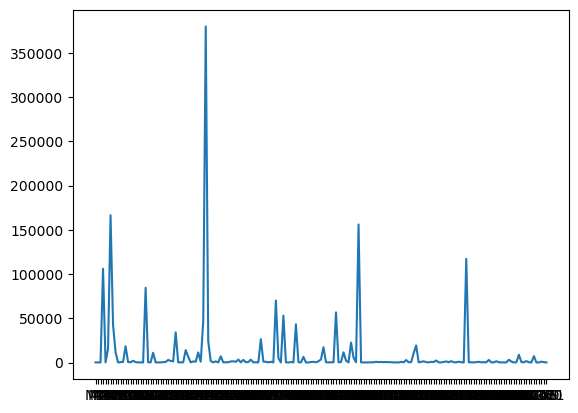

In [6]:
df_mtblt= df.drop(columns=["SampleType", "HealthState", "SmokingStatus", "Sex", "Output"], axis=1)
print(df_mtblt.columns)
_ = plt.plot(df_mtblt.iloc[0])

Abbiamo visualizzato lo spettro del primo campione.

### 3. Extract X & Y

In [5]:
X = df.drop(columns=['SampleType', 'HealthState', 'Output'])
X_features_names = X.columns
y = df.Output

### 3.1 Data Imputation

Confrontiamo due delle tecniche di imputazione più note: Iterative Imputation e KNN Imputation.

In [6]:
# Confrontiamo KNNImputer e IterativeImputer

# IterativeImputer
imputer_it = IterativeImputer(max_iter=10)
imputer_it.fit(X)
X[:] = imputer_it.transform(X)
X_it = X.copy()

# KNNImputer
imputer_knn = KNNImputer(n_neighbors=1)
imputer_knn.fit(X)
X[:] = imputer_knn.fit_transform(X)
X_knn = X.copy()

### 3.2 Train-test Split

In [10]:
X_train_it, X_test_it, y_train_it, y_test_it = train_test_split(X_it, y, test_size=0.2, random_state=42)
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y, test_size=0.2, random_state=42)

### 4. Build Model

In [16]:
# Definiamo i modelli
model_it = RandomForestClassifier(random_state=42)
model_knn = RandomForestClassifier(random_state=42)

# Addestriamo i modelli   
model_it.fit(X_train_it, y_train_it)
model_knn.fit(X_train_knn, y_train_knn)

# Eseguiamo le previsioni sui dati di test
predictions_it = model_it.predict(X_test_it)
predictions_knn = model_knn.predict(X_test_knn)

### 5. Initial Model Evaluation

In [17]:
# Valutiamo le prestazioni del modello con IterativeImputer
accuracy_it = metrics.accuracy_score(y_test_it, predictions_it)
precision_it = metrics.precision_score(y_test_it, predictions_it)
recall_it = metrics.recall_score(y_test_it, predictions_it)
f1_it = metrics.f1_score(y_test_it, predictions_it)
roc_auc_it = metrics.roc_auc_score(y_test_it, predictions_it)

# Valutiamo le prestazioni del modello con KNNImputer
accuracy_knn = metrics.accuracy_score(y_test_knn, predictions_knn)
precision_knn = metrics.precision_score(y_test_knn, predictions_knn)
recall_knn = metrics.recall_score(y_test_knn, predictions_knn)
f1_knn = metrics.f1_score(y_test_knn, predictions_knn)
roc_auc_knn = metrics.roc_auc_score(y_test_knn, predictions_knn)

print(f'Accuratezza con Iterative Imputer: {accuracy_it}')
print(f'Precision con Iterative Imputer: {precision_it}')
print(f'Recall con Iterative Imputer: {recall_it}')
print(f'F1-score con Iterative Imputer: {f1_it}')
print(f'ROC AUC con Iterative Imputer: {roc_auc_it}')
print("------------------------------------------")
print(f'Accuratezza con KNNImputer: {accuracy_knn}')
print(f'Precision con KNNImputer: {precision_knn}')
print(f'Recall con KNNImputer: {recall_knn}')
print(f'F1-score con KNNImputer: {f1_knn}')
print(f'ROC AUC con KNNImputer: {roc_auc_knn}')


Accuratezza con Iterative Imputer: 0.6486486486486487
Precision con Iterative Imputer: 0.7368421052631579
Recall con Iterative Imputer: 0.6363636363636364
F1-score con Iterative Imputer: 0.6829268292682926
ROC AUC con Iterative Imputer: 0.6515151515151516
------------------------------------------
Accuratezza con KNNImputer: 0.6486486486486487
Precision con KNNImputer: 0.7368421052631579
Recall con KNNImputer: 0.6363636363636364
F1-score con KNNImputer: 0.6829268292682926
ROC AUC con KNNImputer: 0.6515151515151516


I risultati sono identici, proseguiamo le analisi con *model_knn* e *X_knn*. Tuttavia, le prestazioni del modello sono ancora deludenti, di conseguenza è necessario proseguire l'analisi con tecniche come *data augmentation* e *hyperparameter optimization*.

In [18]:
# Testiamo diverse configurazioni di K
max = 0
k_best = 0
model = RandomForestClassifier(random_state=42)
for k in range(5, 11): 
    kfolds = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_knn, y, cv=kfolds)
    mean = np.mean(scores)
    if mean > max: 
        max = mean
        k_best = k
    print(f"K={k}, Accuratezza Media: {mean}")

print(f"K ottimale: {k_best}")

K=5, Accuratezza Media: 0.7516516516516518
K=6, Accuratezza Media: 0.778853046594982
K=7, Accuratezza Media: 0.7076923076923077
K=8, Accuratezza Media: 0.762598814229249
K=9, Accuratezza Media: 0.7626984126984127
K=10, Accuratezza Media: 0.7736842105263158
K ottimale: 6


### 6. Hyperparameters Optimization

Il numero ottimale di K è 6.

In [20]:
# Creiamo l'oggetto KFold per la Cross-Validation con il numero di fold ottimale
kfolds = KFold(n_splits=k_best, shuffle=True, random_state=42)

Accuratezza media: 0.778853046594982
Deviazione standard: 0.05022655216939021


### 6.2 KNN Imputator Optimization

In [35]:
knn_classifier = KNNImputer()

# Definiamo il dominio di ricerca
param_space = {'n_neighbors': (1, 20)}

# Creiamo l'oggetto BayesSearchCV
# 'n_iter' determina quanti set distinti di iperparametri verranno esplorati durante la ricerca
# 'cv' indica il numero di fold nell'esecuzione della cross-validation
grid_search = GridSearchCV(knn_classifier, param_space, cv=kfolds, scoring='accuracy', n_jobs=-1)

# Addestriamo il modello sui dati
grid_search.fit(X_knn, y)

# Visualizziamo i risultati dell'ottimizzazione bayesiana
print("Migliore configurazione di parametri:", grid_search.best_params_)

Migliore configurazione di parametri: {'n_neighbors': 1}


/Users/nova/Programming/anaconda3/envs/thesis/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/nova/Programming/anaconda3/envs/thesis/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/nova/Programming/anaconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/nova/Programming/anaconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
 

In [36]:
# KNNImputer
imputer_knn = KNNImputer(n_neighbors=grid_search.best_params_['n_neighbors'])
imputer_knn.fit(X)
X[:] = imputer_knn.fit_transform(X)
X_knn = X.copy()

### 6.3 Model Hyperparameters

In [24]:
# Qui di seguito effetuiamo il tuning degli iperparametri del modello

# Creiamo un nuovo modello Random Forest
model_2 = RandomForestClassifier(random_state=42)

# Definiamo la griglia con i parametri da testare
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 10, 15, 20, 25],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [2, 3, 4]
}

# Creiamo l'oggetto GridSearchCV
grid_search = GridSearchCV(model_2, param_grid, scoring='accuracy', cv=k_best)

# Eseguiamo la ricerca e cross-validation sui dati di addestramento
grid_search.fit(X_knn, y)

# Ottieniamo i migliori parametri
best_params = grid_search.best_params_

# Creiamo un nuovo modello con i migliori parametri
best_model = RandomForestClassifier(**best_params)

# Addestriamo il nuovo modello sui dati di addestramento
best_model.fit(X_knn, y)

# Applichiamo la K-fold Cross-Validation
scores = cross_val_score(best_model, X_knn, y, cv=kfolds, scoring='accuracy')

In [37]:
print(f'Accuratezza media: {scores.mean()}')
print(best_params)

Accuratezza media: 0.768100358422939
{'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}


### 7. Feature Selection

In [38]:
max_fs = 0 
k_fs = 0
best_features = []

for k in range(2, len(X_knn.columns)):
    top_features = SelectKBest(score_func=chi2, k=k).fit(X_knn, y).get_support(indices=True)
    X_top = X_knn.iloc[:, top_features]
    
    scores = cross_val_score(best_model, X_top, y, cv=kfolds, scoring='accuracy')
    mean = np.mean(scores)
    
    if mean > max_fs: 
        max_fs = mean
        k_fs = k
        best_features = X_knn.columns[top_features].tolist()

    print(f"K={k}, Accuratezza Media: {mean}")

print(f"K ottimale: {k_fs}")
print(f"Accuratezza media ottimale: {max_fs}")
print(f"Features ottimali: {best_features}")

Index(['SmokingStatus', 'Sex', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8',
       ...
       'M172', 'M173', 'M174', 'M175', 'M176', 'M177', 'M178', 'M179', 'M180',
       'M181'],
      dtype='object', length=183)


In [ ]:
X_top = X_knn[best_features]
scores = cross_val_score(best_model, X_top, y, cv=kfolds, scoring='accuracy')
print(f'Accuratezza media: {scores.mean()}')

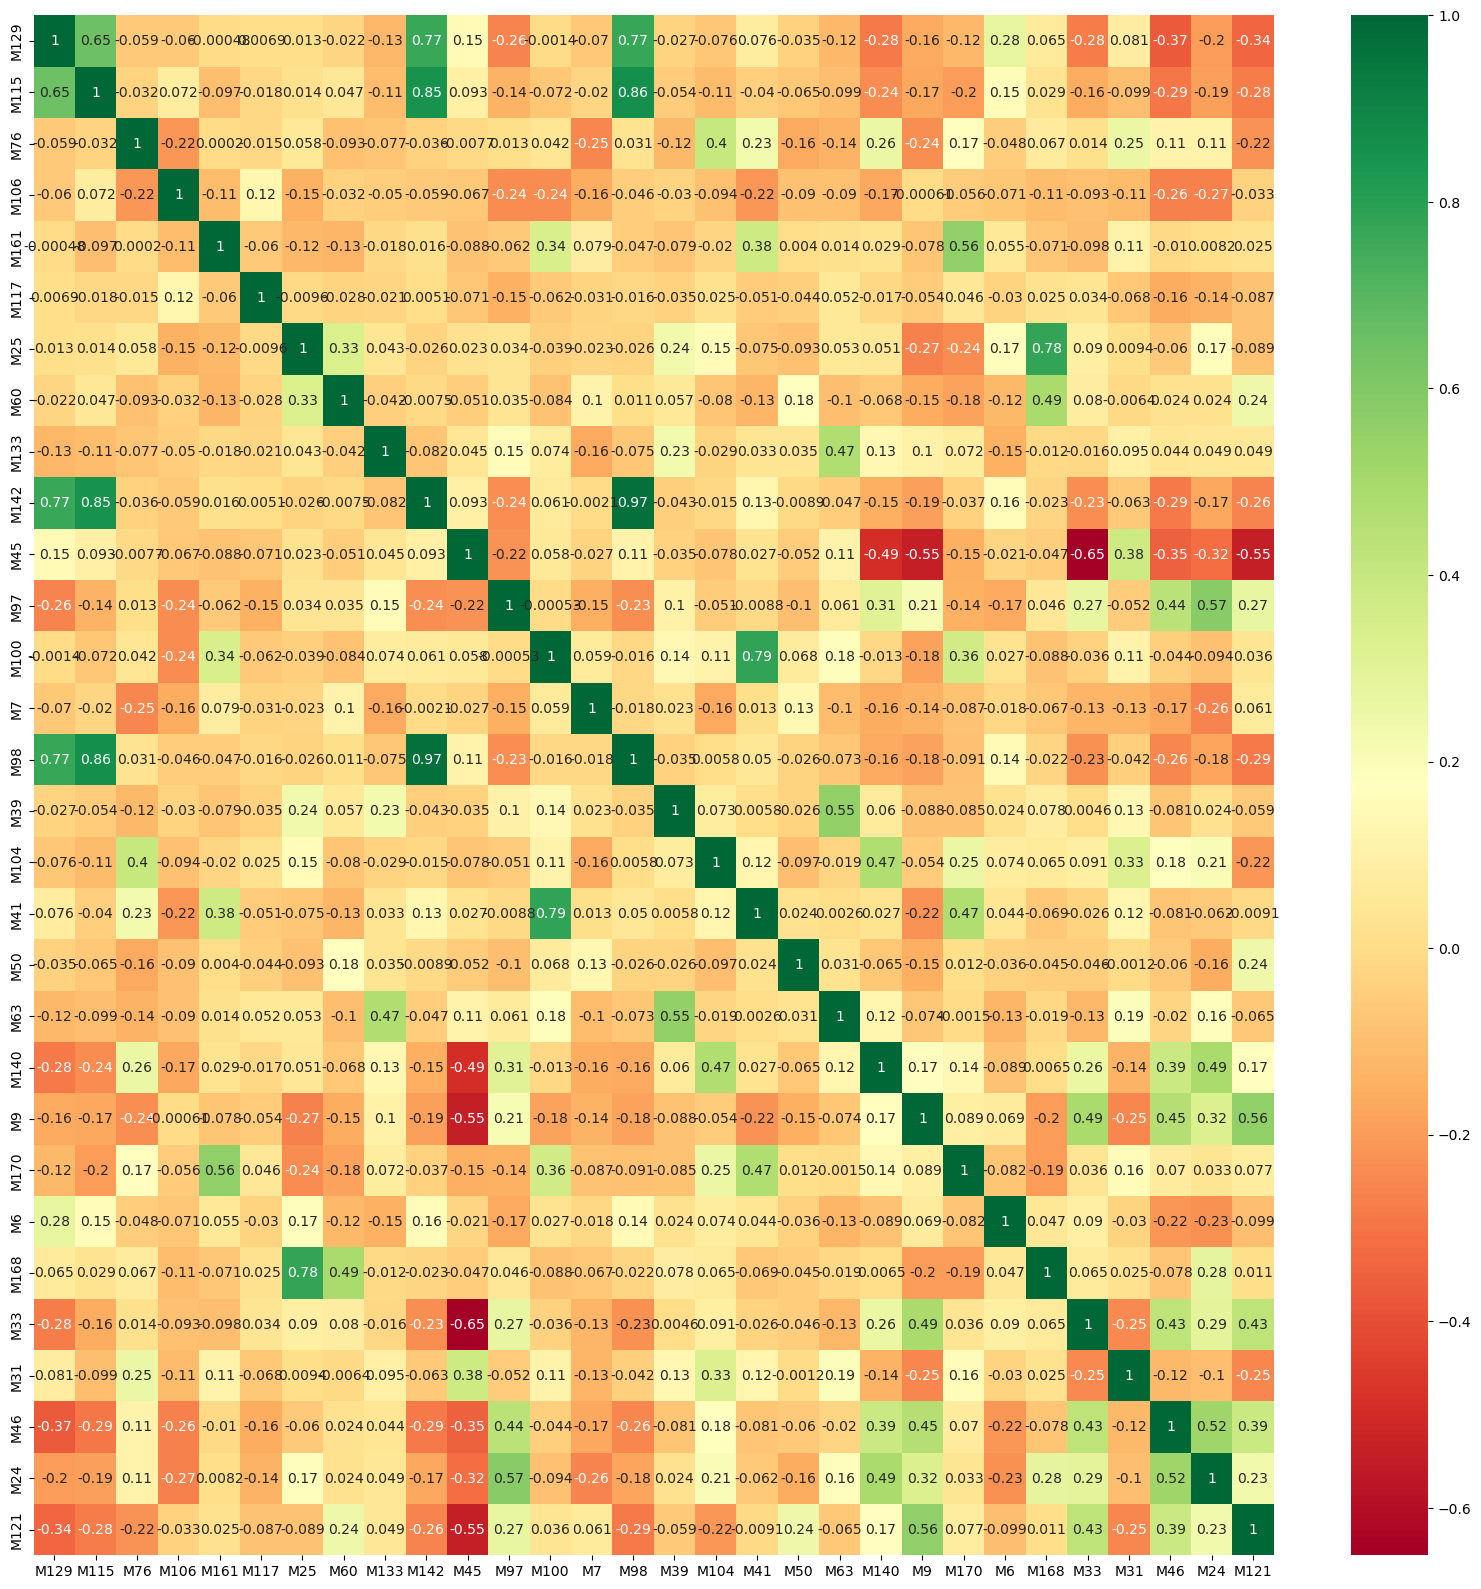

In [16]:
# Otteniamo le correlazioni tra le features
corrmat = X_top.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(k_fs, k_fs))

# Generiamo il grafico delle correlazioni
g=sns.heatmap(X_top[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### 8. Data Augmentation

In [66]:
# Definiamo la funzione per la Data Augmentation (https://github.com/EBjerrum/Deep-Chemometrics)
def dataaugment(x, betashift, slopeshift, multishift):

    beta = np.random.random(size=(x.shape[0],1))*2*betashift-betashift
    slope = np.random.random(size=(x.shape[0],1))*2*slopeshift-slopeshift + 1
    # Calcoliamo la posizione relativa
    axis = np.array(range(x.shape[1]))/float(x.shape[1])
    # Calcoliamo l'offset per ogni riga
    offset = slope*(axis) + beta - axis - slope/2. + 0.5

    # Calcoliamo il fattore di moltiplicazione
    multi = np.random.random(size=(x.shape[0],1))*2*multishift-multishift + 1

    x_augmented = multi*x + offset

    return x

In [67]:
# Estraiamo le features relative ai metaboliti 
X_mtblt=X_knn.drop(columns=["Sex", "SmokingStatus"], axis=1)
print(X_mtblt.columns)

Index(['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10',
       ...
       'M172', 'M173', 'M174', 'M175', 'M176', 'M177', 'M178', 'M179', 'M180',
       'M181'],
      dtype='object', length=181)


Per illustrare la Data Augmentation, applichiamola prima di tutto a un singolo campione.

(100, 181)


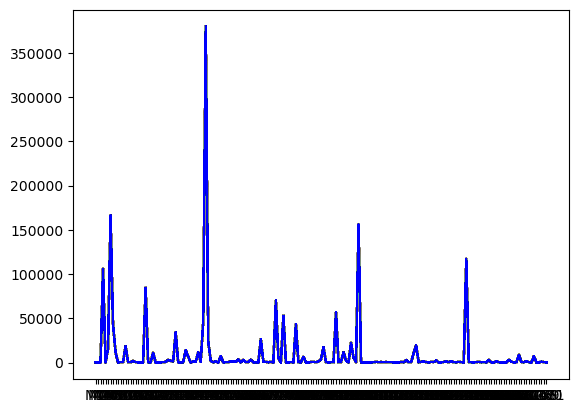

In [72]:
# Estraiamo il primo campione
X_da = X_mtblt.iloc[0:1]

# Ripetiamo il campione k volte
k = 100
X_da = pd.concat([X_da] * k)

# Applichiamo la Data Augmentation
X_aug = dataaugment(X_da, betashift = 0.5, slopeshift = 0.5, multishift = 0.5)
    
plt.plot(X_aug.T)
_= plt.plot(X_da.T, lw=1, c='b')
print(X_aug.shape)

Il grafico blu rappresenta il campione originale: tutto il resto rappresenta le pertubazioni che abbiamo creato. 

In [73]:
shift = np.std(X_mtblt)*0.1
print(shift)

M1        46.685586
M2        72.907349
M3         5.288986
M4      1930.535070
M5         5.705333
           ...     
M177       5.954304
M178       8.649348
M179     100.816872
M180      28.631963
M181       5.255294
Length: 181, dtype: float64


In [74]:
k = 10
X_aug = pd.concat([X_mtblt] * k)
X_aug = dataaugment(X_aug, betashift = 0.01, slopeshift = 0.01, multishift = 0.01)
print(X_aug.shape)

# La variabile y viene semplicemente ripetuta
y_aug = pd.concat([y] * k)
print(y_aug.shape)

(1810, 181)
(1810,)


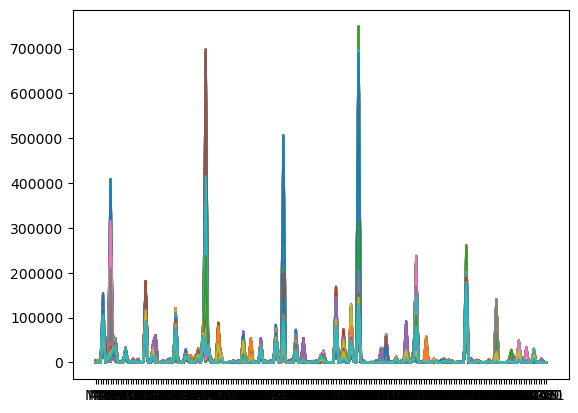

In [75]:
_ = plt.plot(X_aug.T)

Proviamo a fare la stessa cosa con X_top.

In [76]:
k = 100
print(X_top.shape)
X_aug = pd.concat([X_top] * k)
print(X_aug.shape)
X_aug = dataaugment(X_aug, betashift = 0.05, slopeshift = 0.05, multishift = 0.05)
print(X_aug.shape)

# La variabile y viene semplicemente ripetuta
y_aug = pd.concat([y] * k)
print(y_aug.shape)

(181, 10)
(18100, 10)
(18100, 10)
(18100,)


In [77]:
X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, test_size=0.2, stratify=y_aug)
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Valutiamo le prestazioni del modello
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
roc_auc = metrics.roc_auc_score(y_test, y_pred)

# Stampiamo i risultati
print(f'Accuratezza: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'ROC AUC: {roc_auc}')

Accuratezza: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
ROC AUC: 1.0


Proviamo quindi a valutare le prestazioni del modello Random Forest (RF).

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, test_size=0.2, stratify=y_aug)
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Valutiamo le prestazioni del modello
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
roc_auc = metrics.roc_auc_score(y_test, y_pred)

# Stampiamo i risultati
print(f'Accuratezza: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'ROC AUC: {roc_auc}')

Accuratezza: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
ROC AUC: 1.0


### 9. Results